In [2]:
!pwd

/home/studio-lab-user/pranith/fastai_part1/Lesson1/Lesson


In [3]:
!pip install -Uqq fastai --quiet #checking the latest version of fastai

## Step 1: Download images of birds and non-birds

In [4]:
from fastcore.all import *
import time

# def search_images(term,max_images=200):
#     url = 'https://duckduckgo.com/'
#     res = urlread(url,data={'q':term})
#     searchObj = re.search(r'vqd=([\d-]+)\&',res)
#     requestUrl = url + 'i.js'
#     params = dict(l='us-en',o='json',q=term,vqd=searchObj.group(1),f=',,,',p='1',v7exp='a')
#     urls,data = set(),{'next':1}
#     while len(urls)<max_images and 'next' in data:
#         data = urljson(requestUrl,data=params)
#         url.update(L(data['results']).itemgot('image'))
#         requestUrl = url + data['next']
#         time.sleep(0.2)
#     return L(urls)[:max_images]

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
# If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos',max_images=1)
urls[0]

Searching for 'bird photos'


'https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

...and then download a URL and take a look at it:

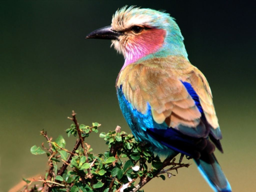

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


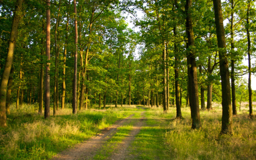

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

In [31]:
# parent_label

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

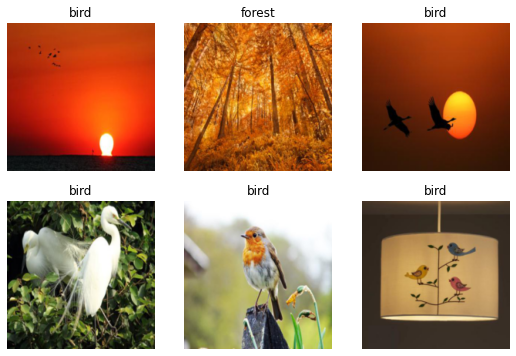

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [33]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.069447,0.092625,0.066667,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.190403,0.025124,0.000000,00:00
1,0.144330,0.004786,0.000000,00:00
2,0.120963,0.005341,0.000000,00:00


## Step 3: Use our model (and build your own!)
Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

# other vision models
Computer vision segmentation

In [34]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.426584,2.165636,00:01


epoch,train_loss,valid_loss,time
0,1.814275,1.694197,00:01
1,1.577167,1.555455,00:01
2,1.436042,1.292657,00:01
3,1.323402,1.023422,00:01
4,1.202675,0.866574,00:01
5,1.089179,0.803461,00:01
6,0.995948,0.775852,00:01
7,0.922575,0.766780,00:01


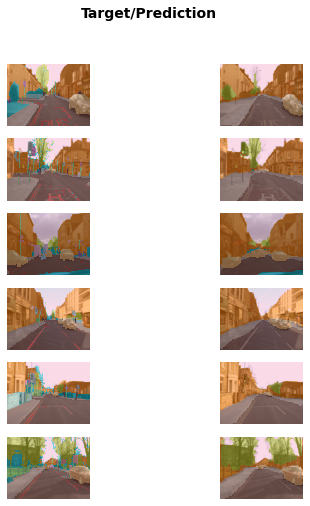

In [35]:
learn.show_results(max_n=6, figsize=(7,8))

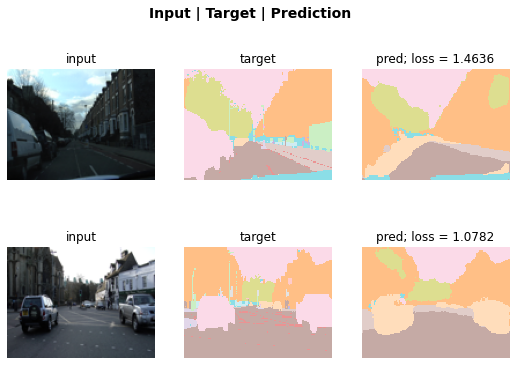

In [36]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=2)